<a href="https://colab.research.google.com/github/Mund99/DSUB_5.0/blob/main/stockprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install utils
!pip install mxnet 
!pip install warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [ ]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [ ]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [ ]:
dataset_ex_df = pd.read_csv('https://raw.githubusercontent.com/Mund99/StockForecastingModel/main/goldmansachs_financialdata.csv', header=0, parse_dates=[0], date_parser=parser)
dataset_ex_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,167.289993,170.130005,166.929993,168.839996,140.212372,6401800
1,2010-01-04,170.050003,174.250000,169.509995,173.080002,143.733444,9135000
2,2010-01-05,173.000000,176.259995,172.570007,176.139999,146.274658,11659400
3,2010-01-06,175.380005,175.380005,173.759995,174.259995,144.713379,7381100
4,2010-01-07,174.320007,178.750000,173.949997,177.669998,147.545212,8727400
...,...,...,...,...,...,...,...
2260,2018-12-24,159.000000,160.000000,154.309998,156.350006,146.146851,3783500
2261,2018-12-26,157.000000,163.110001,151.699997,162.929993,152.297424,7054700
2262,2018-12-27,160.119995,165.410004,159.020004,165.410004,154.615616,4973000
2263,2018-12-28,165.639999,165.949997,162.020004,163.029999,152.390961,4110500


In [ ]:
dataset_ex_df[['Date', 'Close']].head(3)


,Date,Close
0,2009-12-31,168.839996
1,2010-01-04,173.080002
2,2010-01-05,176.139999


In [ ]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2265 number of days in the dataset.


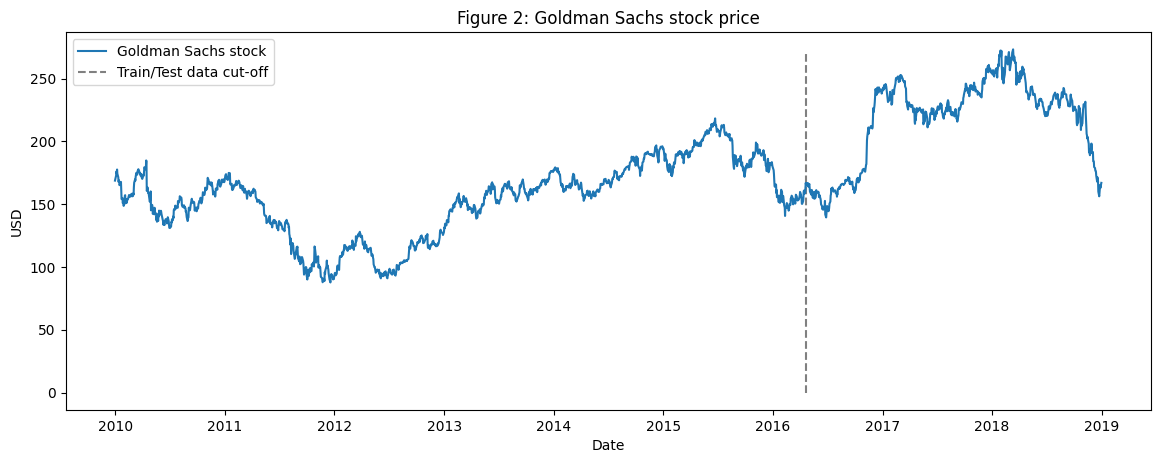

In [ ]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [ ]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1585. Number of test days: 680.


In [ ]:
def get_technical_indicators(dataset):
    df = pd.DataFrame(dataset)
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = df.ewm(span=26)
    dataset['12ema'] = df.ewm(span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [ ]:
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

In [ ]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Date','Close']])
dataset_TI_df = dataset_TI_df.iloc[20:]
dataset_TI_df

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,2010-02-01,153.130005,152.374285,164.220476,160.321839,156.655072,-3.666767,9.607375,183.435226,145.005726,152.113609,152.130005,5.024735
21,2010-02-02,156.940002,152.777143,163.653809,160.014868,156.700047,-3.314821,9.480630,182.615070,144.692549,155.331204,155.940002,5.049471
22,2010-02-03,157.229996,153.098572,162.899047,159.766235,156.783365,-2.982871,9.053702,181.006450,144.791644,156.597065,156.229996,5.051329
23,2010-02-04,150.679993,153.069999,161.686666,158.967168,155.827031,-3.140137,8.940246,179.567158,143.806174,152.652350,149.679993,5.008500
24,2010-02-05,154.160004,153.449999,160.729523,158.550196,155.566566,-2.983631,8.151912,177.033348,144.425699,153.657453,153.160004,5.031483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2018-12-24,156.350006,166.620002,179.774763,182.277728,170.924864,-11.352864,12.007080,203.788923,155.760603,158.564897,155.350006,5.045681
2261,2018-12-26,162.929993,165.214286,178.528572,180.844563,169.694884,-11.149679,11.991685,202.511942,154.545201,161.474961,161.929993,5.087164
2262,2018-12-27,165.410004,164.842859,177.150953,179.701262,169.035672,-10.665590,11.677966,200.506885,153.795021,164.098323,164.410004,5.102363
2263,2018-12-28,163.029999,163.632858,175.692858,178.466354,168.111722,-10.354632,10.810508,197.313874,154.071842,163.386107,162.029999,5.087781


In [ ]:
dataset_TI_df.head()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
20,2010-02-01,153.130005,152.374285,164.220476,160.321839,156.655072,-3.666767,9.607375,183.435226,145.005726,152.113609,152.130005,5.024735
21,2010-02-02,156.940002,152.777143,163.653809,160.014868,156.700047,-3.314821,9.480630,182.615070,144.692549,155.331204,155.940002,5.049471
22,2010-02-03,157.229996,153.098572,162.899047,159.766235,156.783365,-2.982871,9.053702,181.006450,144.791644,156.597065,156.229996,5.051329
23,2010-02-04,150.679993,153.069999,161.686666,158.967168,155.827031,-3.140137,8.940246,179.567158,143.806174,152.652350,149.679993,5.008500
24,2010-02-05,154.160004,153.449999,160.729523,158.550196,155.566566,-2.983631,8.151912,177.033348,144.425699,153.657453,153.160004,5.031483


In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

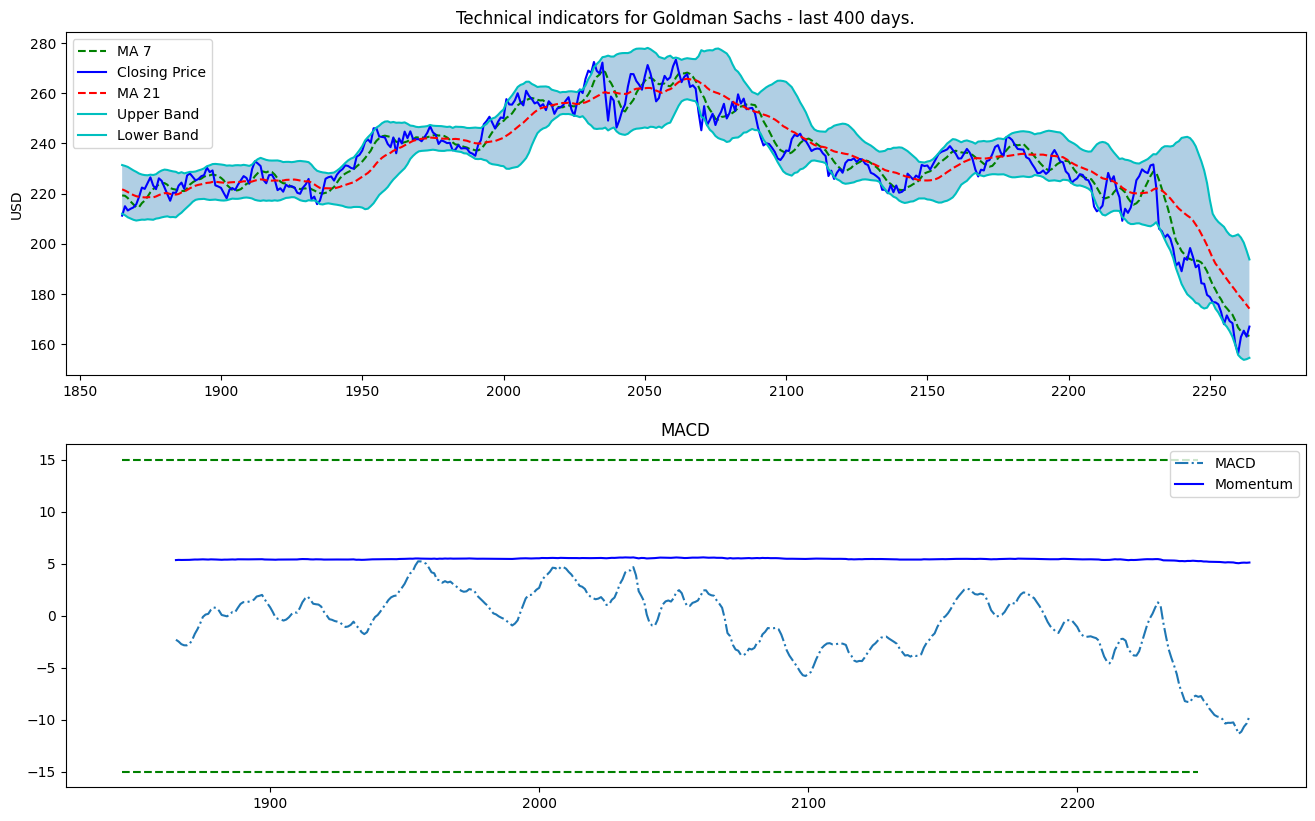

In [ ]:
plot_technical_indicators(dataset_TI_df, 400)

In [ ]:
# just import bert
!pip install bert 
import bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bert: filename=bert-2.2.0-py3-none-any.whl size=3765 sha256=a8a7a5bb4e231a066695b2670cd1d7947e28935250e7a5e8069cee672f4bd492
  Stored in directory: /root/.cache/pip/wheels/bb/31/1b/c05f362e347429b7436954d1a2280fe464731e8f569123a848
  Created wheel for erlastic: filename=erlastic-2.0.0-py3-none-any.whl size=6794 sha256=3874e07f3fac895dc24ca3b42faa095eb31b79b786d9e8be561b2078ff18f9b1
  Stored in directory: /root/.cache/pip/wheels/94/f1/b4/0b98b1e94775da6a0b1130e342d22af05cd269e1172c19f40f
Successfully built bert erlastic


In [132]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [133]:
close_fft = np.fft.fft(np.asarray(data_FT['GS'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

KeyError: ignored

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['GS']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [ ]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

In [ ]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [ ]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [ ]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [ ]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='gelu')

In [ ]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [ ]:
print(net)

In [ ]:
VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 11, Activation(sigmoid))
  )
)

In [ ]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

In [ ]:
dataset_total_df['Date'] = dataset_ex_df['Date']

In [ ]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)

In [ ]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

In [ ]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)

In [ ]:
x_pca = StandardScaler().fit_transform(vae_added_df)

In [ ]:
principalComponents = pca.fit_transform(x_pca)

In [ ]:
principalComponents.n_components_

In [ ]:
gan_num_features = dataset_total_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

In [ ]:
print(lstm_model)

In [ ]:
RNNModel(
  (rnn): LSTM(112 -> 500, TNC)
  (decoder): Dense(500 -> 1, linear)
)

In [ ]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [ ]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500

plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)])
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))
    
# ... other parts of the GAN

In [ ]:
print(cnn_net)

In [ ]:
# Initialize the optimizer
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [ ]:
from utils import plot_prediction

In [ ]:
plot_prediction('Predicted and Real price - after first epoch.')

In [ ]:
plot_prediction('Predicted and Real price - after first 50 epochs.')

In [ ]:
plot_prediction('Predicted and Real price - after first 200 epochs.')

In [ ]:
plot_prediction('Final result.')